<a href="https://colab.research.google.com/github/SANJAY729/Decision_Tree/blob/master/allo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import copy

In [24]:
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy


def InfoGain(data,split_attribute_name,target_name="class"):
    total_entropy = entropy(data[target_name])
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain


def ID3(data,originaldata,features,max_depth,target_attribute_name="class",parent_node_class = None):
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    elif len(data) == 0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    elif len(features) == 0 or max_depth == 0:
        return parent_node_class
    
    else:
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        item_values = [InfoGain(data,feature,target_attribute_name) for feature in features] 
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        tree = {best_feature:{},"recurrence-events":0,"no-recurrence-events":0}
        features = [i for i in features if i != best_feature]
        for value in np.unique(data[best_feature]):
            value = value
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = ID3(sub_data,dataset,features,max_depth-1,target_attribute_name,parent_node_class)
            tree[best_feature][value] = subtree
        return(tree)    


def predict(query,tree):
    default = "no-recurrence-events"
    if (tree["recurrence-events"]>tree["no-recurrence-events"]):
        default = "recurrence-events"
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

def test(data,tree):
    queries = data.iloc[:,1:].to_dict(orient = "records")
    predicted = pd.DataFrame(columns=["predicted"]) 
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree)
    return (np.sum(predicted["predicted"] == data["class"])/len(data))*100
    
def majorityclassutil(query,tree):
    if (query["class"]=="no-recurrence-events"):
        tree["no-recurrence-events"] = tree["no-recurrence-events"] + 1
    else:
        tree["recurrence-events"] = tree["recurrence-events"] + 1
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return majorityclassutil(query,result)
            else:
                return

def majorityclasses(data,tree):
     queries = data.iloc[:,:-1].to_dict(orient = "records")
     for i in range(len(data)):
        majorityclassutil(queries[i],tree)






In [25]:
dataset_init = pd.read_csv('breast-cancer.csv',
                      names=['class','age','menopause','tumor-size','inv-nodes','node-caps','def-malig','breast','breast-quad','irradiat'])
# 1. class: no-recurrence-events, recurrence-events
# 2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
# 3. menopause: lt40, ge40, premeno.
# 4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
# 5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
# 6. node-caps: yes, no.
# 7. deg-malig: 1, 2, 3.
# 8. breast: left, right.
# 9. breast-quad: left-up, left-low, right-up, right-low, central.
# 10. irradiat: yes, no.

dataset_ = dataset_init[dataset_init['node-caps']!='?']
dataset = dataset_[dataset_['breast-quad']!='?']


In [26]:
def train_validation_test_split(s_dataset):
    training_data = s_dataset.iloc[:180].reset_index(drop=True)
    validation_data = s_dataset.iloc[180:230].reset_index(drop=True)
    testing_data = s_dataset.iloc[230:].reset_index(drop=True)
    return training_data,validation_data,testing_data

In [30]:
#QUESTION 1 
###################################################

max_depth = int(input("Enter the maximum depth : "))
accuracy = 0
for i in range (1,11):
    shuffled_data = copy.deepcopy(dataset[1:])
    shuffled_data = shuffled_data.sample(frac=1, random_state = i).reset_index(drop=True)
   # print(shuffled_data.head())   
    training_data,validation_data,testing_data = train_validation_test_split(shuffled_data)
    tree = ID3(training_data,training_data,training_data.columns[1:],max_depth)
    majorityclasses(training_data,tree)
    t_acc=test(testing_data,tree)
    accuracy = accuracy + t_acc
print("The average accuracy over 10 different splits is ",accuracy/10)

Enter the maximum depth : 9
The average accuracy over 10 different splits is  68.2608695652174


1 2 3 4 5 6 7 8 9 

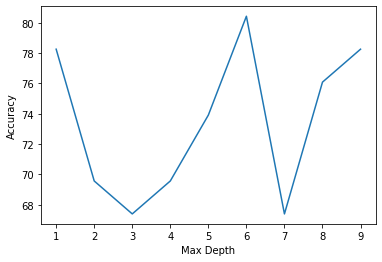

In [31]:
#QUESTION 2
##################################################

x = [1,2,3,4,5,6,7,8,9]
y = []
for i in range (1,10):
    accuracy = 0
    print(i,end=" ")
    for j in range(1,11):
        shuffled_data = copy.deepcopy(dataset[1:])
        shuffled_data = shuffled_data.sample(frac=1, random_state = i+2).reset_index(drop=True)
        training_data,validation_data,testing_data=train_validation_test_split(shuffled_data)
        tree = ID3(training_data,training_data,training_data.columns[1:],i)
        majorityclasses(training_data,tree)
        accuracy = accuracy + test(testing_data,tree)
    y.append(accuracy/10)

plt.plot(x,y)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.show()


In [32]:
def possiblevalues(keys):
    feature = ""
    values = []
    for key in keys:
        if (key == 'no-recurrence-events'):
            continue
        elif (key == 'recurrence-events'):
            continue
        else :
            feature = key
            if (feature == 'age'):
                values = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
            if (feature == 'menopause'):
                values = ['lt40', 'ge40', 'premeno']
            if (feature == 'tumor-size'):
                values = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59']
            if (feature == 'inv-nodes'):
                values = ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26', '27-29', '30-32', '33-35', '36-39']
            if (feature == 'node-caps'):
                values = ['yes', 'no']
            if (feature == 'deg-malig'):
                values = ['1', '2', '3']
            if (feature == 'breast'):
                values = ['left', 'right']
            if (feature == 'breast-quad'):
                values = ['left-up', 'left-low', 'right-up', 'right-low', 'central']
            if (feature == 'irradiat'):
                values = ['yes', 'no']            
    return feature,values

def skip():
  return
def delete_node(tree,node,target):
    if (node==tree):
        return target
    else:
        if isinstance(tree, dict):
            feature, values = possiblevalues(tree.keys())
            for value in values:
                try:
                    tree[feature][value] = copy.deepcopy(delete_node(tree[feature][value],node,target))
                except:
                    skip()
    return tree
def prune_singlenode(tree,initial_accuracy,validation_data):
    initial_tree = copy.deepcopy(tree)
    best_tree = copy.deepcopy(tree)
    current_tree = copy.deepcopy(tree)
    best_accuracy = initial_accuracy
    flag = 0
    queue = []
    node_removed = None
    queue.append(tree)
    while queue!=[]:
        node = queue.pop(0)
        if isinstance(node, dict):
            feature, values = possiblevalues(node.keys())
            for value in values:
                try:
                    queue.append(node[feature][value])
                    
                except:
                    skip()
            if node==initial_tree :
                continue
            
            if node['no-recurrence-events']>node['recurrence-events']:
                current_tree=copy.deepcopy(delete_node(initial_tree,node,'no-recurrence-events'))
            else :
                current_tree=copy.deepcopy(delete_node(initial_tree,node,'recurrence-events'))
            initial_tree = copy.deepcopy(tree)
            current_accuracy = test(validation_data,current_tree)
            if current_accuracy>best_accuracy:
                flag = 1
                best_tree = copy.deepcopy(current_tree)
                node_removed = node
                best_accuracy = current_accuracy    
    return best_tree,best_accuracy,flag

In [33]:
#QUESTION 3
#################################################################

max_depth  = 6 #from the graph
shuffled_data = copy.deepcopy(dataset[1:])
shuffled_data = shuffled_data.sample(frac=1, random_state = 10).reset_index(drop=True)
#ranstate=2,5,6,10 (for max_depth = 6 only)
training_data,validation_data,testing_data = train_validation_test_split(shuffled_data)
tree = ID3(training_data,training_data,training_data.columns[1:],max_depth)
majorityclasses(training_data,tree)

initial_accuracy_validation = test(validation_data,tree)
initial_accuracy_test = test(testing_data,tree)

ini_tree=copy.deepcopy(tree)

new_tree,new_accuracy,flag = prune_singlenode(tree,initial_accuracy_validation,validation_data)
cnt=0
while (flag==1):
    cnt+=1
    new_tree,new_accuracy,flag = prune_singlenode(new_tree,new_accuracy,validation_data)
if cnt==0:
  print('None of the nodes should be pruned')
else:
  print('Number of nodes pruned: ',cnt)
final_accuracy_validation = test(validation_data,new_tree)
final_accuracy_test = test(testing_data,new_tree)
print('Accuracy before pruning on validation set',initial_accuracy_validation)
print('Accuracy before pruning on test set',initial_accuracy_test)
print('Accuracy after pruning on validation set',final_accuracy_validation)
print('Accuracy after pruning on test set',final_accuracy_test)

Number of nodes pruned:  1
Accuracy before pruning on validation set 62.0
Accuracy before pruning on test set 76.08695652173914
Accuracy after pruning on validation set 68.0
Accuracy after pruning on test set 82.6086956521739


In [34]:
#QUESTION 4
########################################################
pprint(new_tree)

{'inv-nodes': {'0-2': 'no-recurrence-events',
               '12-14': {'no-recurrence-events': 1,
                         'recurrence-events': 2,
                         'tumor-size': {'15-19': 'no-recurrence-events',
                                        '25-29': 'recurrence-events',
                                        '30-34': 'recurrence-events'}},
               '15-17': {'menopause': {'ge40': 'no-recurrence-events',
                                       'premeno': 'recurrence-events'},
                         'no-recurrence-events': 2,
                         'recurrence-events': 3},
               '24-26': 'recurrence-events',
               '3-5': {'breast-quad': {'central': 'recurrence-events',
                                       'left_low': {'age': {'30-39': 'recurrence-events',
                                                            '40-49': {'menopause': {'ge40': 'recurrence-events',
                                                                          